# Start Pooling

In [104]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import dirichlet
import scipy.optimize as sco
import random
from pathlib import Path
import pickle

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import functions as fct

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x, result.fun  # Return the optimized weights and the minimized risk

## Define Countries and Variables for Cat Bond Development

In [106]:
#choose country
countries = [480, 212, 882, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585] #[480, 212, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 882, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]
countries_150 = [332, 388, 214, 44, 548, 192, 84, 90] 
fiji = [242]
countries_30 = [480, 212, 670, 28, 52, 662, 659, 308, 882, 780, 570, 776, 174, 184, 584, 585]

countries_str = ['MUS', 'DMA', 'WSM', 'HIT', 'VCT', 'ATG', 'JAM', 'BRB', 'LCA', 'KNA', 'GRD', 'DOM', 'BHS', 'VUT', 'FJI', 'TTO', 'CUB', 'NIU', 'BLZ', 'TON', 'SLB', 'COM', 'COK', 'MHL', 'PLW']
countries_str_x_label = ['MUS', 'DMA', 'WSM', 'HIT', 'VCT', 'ATG', 'JAM', 'BRB', 'LCA', 'KNA', 'GRD', 'DOM', 'BHS', 'VUT', 'FJI', 'TTO', 'CUB', 'NIU', 'BLZ', 'TON', 'SLB', 'COM', 'COK', 'MHL', 'PLW', 'Pool']

scenario_1 = [[480, 212, 882, 332, 670, 28, 388, 52, 662, 659, 308, 214, 44, 548, 242, 780, 192, 570, 84, 776, 90, 174, 184, 584, 585]] 
scenario_2 = [[480, 332, 28, 388, 52, 662, 659, 214, 44, 242, 780, 192, 184, 584], [212, 882, 670, 308, 548, 570, 84, 776, 90, 174, 585]]
scenario_3 = [[212, 882, 670, 308, 548, 570, 84, 776, 90, 174, 184], [584, 585], [480, 332, 28, 388, 52, 662, 659, 214, 44, 242, 780, 192]]
scenario_4 = [[212, 882, 670, 308, 548, 84, 776, 90, 174], [480, 332, 388, 214, 192], [584, 585], [28, 52, 662, 659, 44, 242, 780, 570, 184]]
scenario_5 = [[776, 90, 174, 184], [212, 882, 670, 308, 548, 84], [584, 585], [480, 332, 52, 662, 659, 44, 242, 780, 570], [28, 388, 214, 192]]

#set risk free rate, either single value or array
rf_rates = 0.00
#set risk muliplier reported by artems
artemis_multiplier = 4.54
#set sharpe ratio to beat
target_sharpe = 0.5
#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(file_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"),want_plot=False)
a, k, b = params_ibrd
#define bond setting
lower_share = 0.05
prot_rp = 250


## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

In [107]:
sng_ann_ret_df_ibrd = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_ibrd.csv")
sng_ann_ret_df_regression = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_regression.csv")
sng_ann_ret_df_artemis = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_artemis.csv")
sng_ann_ret_df_required = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_returns_required.csv")
sng_es_metrics = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/sng_es.csv")
output_path = Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/bond_metrics_sng_dic.pkl")
with open(output_path, "rb") as file:
    bond_metrics_sng_dic = pickle.load(file)

sng_ann_ret_required = sng_ann_ret_df_required.to_dict('series')
sng_ann_ret_artemis = sng_ann_ret_df_artemis.to_dict('series')
sng_ann_ret_regression = sng_ann_ret_df_regression.to_dict('series')
sng_ann_ret_ibrd = sng_ann_ret_df_ibrd.to_dict('series')
sng_es_metrics = sng_es_metrics.to_dict('series')

nominal_sng_dic_df = pd.read_csv("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/nominal_dic_df.csv")
# Specify the output path
output_path = Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/pay_dam_df_dic.pkl")
with open(output_path, "rb") as file:
    pay_dam_df_sng_dic = pickle.load(file)

output_path = Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/simulation_results/premium_dic_sng_dic.pkl")
with open(output_path, "rb") as file:
    premium_dic_sng_dic = pickle.load(file)

nominal_sng_dic = dict(zip(nominal_sng_dic_df["Key"], nominal_sng_dic_df["Value"]))

In [108]:
coverages = []
for key in bond_metrics_sng_dic:
    coverages.append(bond_metrics_sng_dic[key]['Coverage'][0])

exp_lsss = []
att_probs = []
var_95 = []
var_99 = []
es_95 = []
es_99 = []
for key in premium_dic_sng_dic:
    exp_lsss.append(premium_dic_sng_dic[key]['exp_loss'])
    att_probs.append(premium_dic_sng_dic[key]['att_prob'])
    var_99.append(sng_es_metrics[str(key)][0])
    var_95.append(sng_es_metrics[str(key)][2])
    es_99.append(sng_es_metrics[str(key)][4])
    es_95.append(sng_es_metrics[str(key)][6])

exp_lsss = np.array(exp_lsss) * 100
att_probs = np.array(att_probs) * 100
coverages = np.array(coverages) * 100
var_95 = np.array(var_95) * 100
var_99 = np.array(var_99) * 100
es_95 = np.array(es_95) * 100
es_99 = np.array(es_99) * 100

data = {
    'Country': countries_str,
    'Coverage': np.round(coverages,1),
    'Expected Loss': np.round(exp_lsss, 1),
    'Attachment Probability': np.round(att_probs,1),
    'VaR 95': np.round(var_95,1),
    'VaR 99': np.round(var_99,1),
    'ES 95': np.round(es_95,1),
    'ES 99': np.round(es_99,1)
}
df = pd.DataFrame(data)

# Calculate the mean, min, and specified percentiles for each column
statistics = df.describe(percentiles=[.25, .5, .75, 1.0])

# Display the statistics
print(statistics)

latex_table = df.to_latex(index=False, float_format="%.1f", caption="Example Table", label="tab:example_table")
print(latex_table)

        Coverage  Expected Loss  Attachment Probability     VaR 95     VaR 99  \
count  25.000000       25.00000               25.000000  25.000000  25.000000   
mean   80.096000        1.87200                3.748000   7.608000  54.456000   
std    13.901093        0.91766                2.229185  11.481105  28.731459   
min    45.600000        0.40000                0.400000   0.000000   0.000000   
25%    78.600000        1.20000                2.200000   0.000000  52.200000   
50%    86.900000        1.90000                3.900000   0.000000  68.000000   
75%    90.000000        2.70000                5.600000  19.200000  70.700000   
100%   92.000000        3.30000                7.700000  28.100000  78.300000   
max    92.000000        3.30000                7.700000  28.100000  78.300000   

           ES 95      ES 99  
count  25.000000  25.000000  
mean   60.868000  87.732000  
std    15.835212   5.710788  
min    47.400000  69.300000  
25%    49.700000  84.800000  
50%    55

### Create Multi-Country bond

In [109]:
tranches_array = np.array([50, 250, 1000])

ncf_s1 = {}
premiums_s1 = {}
premium_dic_s1 = {}
nominal_s1 = {}
es_metrics_s1 = {}
MES_cty_s1 = {}
tranches_s1 = {}

i = 0
for pool in scenario_1:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s1[str(i)], premiums_s1[str(i)], premium_dic_s1[str(i)], nominal_s1[str(i)], es_metrics_s1[str(i)], MES_cty_s1[str(i)], tranches_s1[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))
        

ncf_s2 = {}
premiums_s2 = {}
premium_dic_s2 = {}
nominal_s2 = {}
es_metrics_s2 = {}
MES_cty_s2 = {}
tranches_s2 = {}

i = 0
for pool in scenario_2:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s2[str(i)], premiums_s2[str(i)], premium_dic_s2[str(i)], nominal_s2[str(i)], es_metrics_s2[str(i)], MES_cty_s2[str(i)], tranches_s2[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))
        

ncf_s3 = {}
premiums_s3 = {}
premium_dic_s3 = {}
nominal_s3 = {}
es_metrics_s3 = {}
MES_cty_s3 = {}
tranches_s3 = {}

i = 0
for pool in scenario_3:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s3[str(i)], premiums_s3[str(i)], premium_dic_s3[str(i)], nominal_s3[str(i)], es_metrics_s3[str(i)], MES_cty_s3[str(i)], tranches_s3[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))
        

ncf_s4 = {}
premiums_s4 = {}
premium_dic_s4 = {}
nominal_s4 = {}
es_metrics_s4 = {}
MES_cty_s4 = {}
tranches_s4 = {}

i = 0
for pool in scenario_4:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s4[str(i)], premiums_s4[str(i)], premium_dic_s4[str(i)], nominal_s4[str(i)], es_metrics_s4[str(i)], MES_cty_s4[str(i)], tranches_s4[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))
        

ncf_s5 = {}
premiums_s5 = {}
premium_dic_s5 = {}
nominal_s5 = {}
es_metrics_s5 = {}
MES_cty_s5 = {}
tranches_s5 = {}

i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5[str(i)], premiums_s5[str(i)], premium_dic_s5[str(i)], nominal_s5[str(i)], es_metrics_s5[str(i)], MES_cty_s5[str(i)], tranches_s5[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis")) 

ncf_s5_a = {}
premiums_s5_a = {}
premium_dic_s5_a = {}
nominal_s5_a = {}
es_metrics_s5_a = {}
MES_cty_s5_a = {}
tranches_s5_a = {}

i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5_a[str(i)], premiums_s5_a[str(i)], premium_dic_s5_a[str(i)], nominal_s5_a[str(i)], es_metrics_s5_a[str(i)], MES_cty_s5_a[str(i)], tranches_s5_a[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                         nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                         opt_cap=True, prem_corr=0.01, ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))

c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 37.25%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 35.5%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 59.33%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 59.55%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 35.46%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 59.01%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 23.58%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 35.82%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


In [110]:
ncf_s5_a_b = {}
premiums_s5_a_b = {}
premium_dic_s5_a_b = {}
nominal_s5_a_b = {}
es_metrics_s5_a_b = {}
MES_cty_s5_a_b = {}
tranches_s5_a_b = {}

i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5_a_b[str(i)], premiums_s5_a_b[str(i)], premium_dic_s5_a_b[str(i)], nominal_s5_a_b[str(i)], es_metrics_s5_a_b[str(i)], MES_cty_s5_a_b[str(i)], tranches_s5_a_b[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                                                            nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                                                            opt_cap=True, prem_corr=0.015, 
                                                                                                                                                                                                            ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))
        
ncf_s5_a_r = {}
premiums_s5_a_r = {}
premium_dic_s5_a_r = {}
nominal_s5_a_r = {}
es_metrics_s5_a_r = {}
MES_cty_s5_a_r = {}
tranches_s5_a_r = {}

i = 0
for pool in scenario_5:
    i += 1
    if len(pool) > 1:
        nominal_dic_pool = {}
        pay_dam_df_dic_pool = {}
        for cty in pool:
            nominal_dic_pool[cty] = nominal_sng_dic[cty]
            pay_dam_df_dic_pool[cty] = pay_dam_df_sng_dic[cty]
        ncf_s5_a_r[str(i)], premiums_s5_a_r[str(i)], premium_dic_s5_a_r[str(i)], nominal_s5_a_r[str(i)], es_metrics_s5_a_r[str(i)], MES_cty_s5_a_r[str(i)], tranches_s5_a_r[str(i)] = bond_fct.mlt_cty_bond(countries=pool,pay_dam_df_dic=pay_dam_df_dic_pool,
                                                                                                                                                                                                            nominals_dic=nominal_dic_pool, tranches_array=tranches_array, 
                                                                                                                                                                                                            opt_cap=True, prem_corr=0.001, 
                                                                                                                                                                                                            ibrd_path=Path("C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis"))

c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 45.41%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 48.89%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)
c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\simulate_multi_cty_bond.py:646: RuntimeWarning: invalid value encountered in scalar divide
  return ((avg_ret - rf) / sigma - target_sharpe)**2


Reduction of Principal: 47.21%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 40.91%


c:\Users\Kai\OneDrive - UT Cloud\Documents\Studium_ETH\Thesis\Code\master_thesis_cat_bonds\functions.py:111: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tranches = pd.concat([tranch_df, pd.DataFrame(rows)], ignore_index=True)


Reduction of Principal: 18.56%


In [111]:
s1_tranches_ann_ret_regr = {}
s1_tranches_ann_ret_ibrd ={}
s1_tranches_ann_ret_requ ={}
s1_tranches_ann_ret_arte ={}

for key in ncf_s1["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s1:
            s1_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s1[pool]['regression'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s1[pool]['ibrd'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s1[pool]['required'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]
            s1_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s1[pool]['artemis'][key] / tranches_s1[pool].loc[tranches_s1[pool]['RP'] == key, 'nominal'].iloc[0]

s2_tranches_ann_ret_regr = {}
s2_tranches_ann_ret_ibrd = {}
s2_tranches_ann_ret_requ = {}
s2_tranches_ann_ret_arte = {}

for key in ncf_s2["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s2:
            s2_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s2[pool]['regression'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s2[pool]['ibrd'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s2[pool]['required'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]
            s2_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s2[pool]['artemis'][key] / tranches_s2[pool].loc[tranches_s2[pool]['RP'] == key, 'nominal'].iloc[0]

s3_tranches_ann_ret_regr = {}
s3_tranches_ann_ret_ibrd = {}
s3_tranches_ann_ret_requ = {}
s3_tranches_ann_ret_arte = {}

for key in ncf_s3["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s3:
            s3_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s3[pool]['regression'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s3[pool]['ibrd'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s3[pool]['required'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]
            s3_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s3[pool]['artemis'][key] / tranches_s3[pool].loc[tranches_s3[pool]['RP'] == key, 'nominal'].iloc[0]


s4_tranches_ann_ret_regr = {}
s4_tranches_ann_ret_ibrd = {}
s4_tranches_ann_ret_requ = {}
s4_tranches_ann_ret_arte = {}

for key in ncf_s4["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s4:
            s4_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s4[pool]['regression'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s4[pool]['ibrd'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s4[pool]['required'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]
            s4_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s4[pool]['artemis'][key] / tranches_s4[pool].loc[tranches_s4[pool]['RP'] == key, 'nominal'].iloc[0]

s5_tranches_ann_ret_regr = {}
s5_tranches_ann_ret_ibrd = {}
s5_tranches_ann_ret_requ = {}
s5_tranches_ann_ret_arte = {}

for key in ncf_s5["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5:
            s5_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5[pool]['regression'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5[pool]['ibrd'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5[pool]['required'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s5[pool]['artemis'][key] / tranches_s5[pool].loc[tranches_s5[pool]['RP'] == key, 'nominal'].iloc[0]


s5_a_tranches_ann_ret_regr = {}
s5_a_tranches_ann_ret_ibrd = {}
s5_a_tranches_ann_ret_requ = {}
s5_a_tranches_ann_ret_arte = {}

for key in ncf_s5_a["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5_a:
            s5_a_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5_a[pool]['regression'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5_a[pool]['ibrd'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5_a[pool]['required'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s5_a[pool]['artemis'][key] / tranches_s5_a[pool].loc[tranches_s5_a[pool]['RP'] == key, 'nominal'].iloc[0]

s5_a_b_tranches_ann_ret_regr = {}
s5_a_b_tranches_ann_ret_ibrd = {}
s5_a_b_tranches_ann_ret_requ = {}
s5_a_b_tranches_ann_ret_arte = {}

for key in ncf_s5_a_b["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5_a_b:
            s5_a_b_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5_a_b[pool]['regression'][key] / tranches_s5_a_b[pool].loc[tranches_s5_a_b[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_b_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5_a_b[pool]['ibrd'][key] / tranches_s5_a_b[pool].loc[tranches_s5_a_b[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_b_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5_a_b[pool]['required'][key] / tranches_s5_a_b[pool].loc[tranches_s5_a_b[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_b_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s5_a_b[pool]['artemis'][key] / tranches_s5_a_b[pool].loc[tranches_s5_a_b[pool]['RP'] == key, 'nominal'].iloc[0]

s5_a_r_tranches_ann_ret_regr = {}
s5_a_r_tranches_ann_ret_ibrd = {}
s5_a_r_tranches_ann_ret_requ = {}
s5_a_r_tranches_ann_ret_arte = {}

for key in ncf_s5_a_r["1"]['regression']:
    if key != 'Total':
        for pool in ncf_s5_a_r:
            s5_a_r_tranches_ann_ret_regr[f"{pool}: {key}"] = ncf_s5_a_r[pool]['regression'][key] / tranches_s5_a_r[pool].loc[tranches_s5_a_r[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_r_tranches_ann_ret_ibrd[f"{pool}: {key}"] = ncf_s5_a_r[pool]['ibrd'][key] / tranches_s5_a_r[pool].loc[tranches_s5_a_r[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_r_tranches_ann_ret_requ[f"{pool}: {key}"] = ncf_s5_a_r[pool]['required'][key] / tranches_s5_a_r[pool].loc[tranches_s5_a_r[pool]['RP'] == key, 'nominal'].iloc[0]
            s5_a_r_tranches_ann_ret_arte[f"{pool}: {key}"] = ncf_s5_a_r[pool]['artemis'][key] / tranches_s5_a_r[pool].loc[tranches_s5_a_r[pool]['RP'] == key, 'nominal'].iloc[0]



s1_ann_ret_regr = {}
s1_ann_ret_ibrd = {}
s1_ann_ret_requ = {}
s1_ann_ret_arte = {}
for pool in ncf_s1:
    s1_ann_ret_regr[pool] = 0
    s1_ann_ret_ibrd[pool] = 0
    s1_ann_ret_requ[pool] = 0
    s1_ann_ret_arte[pool] = 0
    for rp in ncf_s1[pool]['regression']:
        if rp != 'Total':
            s1_ann_ret_regr[pool] += ncf_s1[pool]['regression'][rp]
            s1_ann_ret_ibrd[pool] += ncf_s1[pool]['ibrd'][rp]
            s1_ann_ret_requ[pool] += ncf_s1[pool]['required'][rp]
            s1_ann_ret_arte[pool] += ncf_s1[pool]['artemis'][rp]


s2_ann_ret_regr = {}
s2_ann_ret_ibrd = {}
s2_ann_ret_requ = {}
s2_ann_ret_arte = {}
for pool in ncf_s2:
    s2_ann_ret_regr[pool] = 0
    s2_ann_ret_ibrd[pool] = 0
    s2_ann_ret_requ[pool] = 0
    s2_ann_ret_arte[pool] = 0
    for rp in ncf_s2[pool]['regression']:
        if rp != 'Total':
            s2_ann_ret_regr[pool] += ncf_s2[pool]['regression'][rp]
            s2_ann_ret_ibrd[pool] += ncf_s2[pool]['ibrd'][rp]
            s2_ann_ret_requ[pool] += ncf_s2[pool]['required'][rp]
            s2_ann_ret_arte[pool] += ncf_s2[pool]['artemis'][rp]


s3_ann_ret_regr = {}
s3_ann_ret_ibrd = {}
s3_ann_ret_requ = {}
s3_ann_ret_arte = {}
for pool in ncf_s3:
    s3_ann_ret_regr[pool] = 0
    s3_ann_ret_ibrd[pool] = 0
    s3_ann_ret_requ[pool] = 0
    s3_ann_ret_arte[pool] = 0
    for rp in ncf_s3[pool]['regression']:
        if rp != 'Total':
            s3_ann_ret_regr[pool] += ncf_s3[pool]['regression'][rp]
            s3_ann_ret_ibrd[pool] += ncf_s3[pool]['ibrd'][rp]
            s3_ann_ret_requ[pool] += ncf_s3[pool]['required'][rp]
            s3_ann_ret_arte[pool] += ncf_s3[pool]['artemis'][rp]


s4_ann_ret_regr = {}
s4_ann_ret_ibrd = {}
s4_ann_ret_requ = {}
s4_ann_ret_arte = {}
for pool in ncf_s4:
    s4_ann_ret_regr[pool] = 0
    s4_ann_ret_ibrd[pool] = 0
    s4_ann_ret_requ[pool] = 0
    s4_ann_ret_arte[pool] = 0
    for rp in ncf_s4[pool]['regression']:
        if rp != 'Total':
            s4_ann_ret_regr[pool] += ncf_s4[pool]['regression'][rp]
            s4_ann_ret_ibrd[pool] += ncf_s4[pool]['ibrd'][rp]
            s4_ann_ret_requ[pool] += ncf_s4[pool]['required'][rp]
            s4_ann_ret_arte[pool] += ncf_s4[pool]['artemis'][rp]


s5_ann_ret_regr = {}
s5_ann_ret_ibrd = {}
s5_ann_ret_requ = {}
s5_ann_ret_arte = {}
for pool in ncf_s5:
    s5_ann_ret_regr[pool] = 0
    s5_ann_ret_ibrd[pool] = 0
    s5_ann_ret_requ[pool] = 0
    s5_ann_ret_arte[pool] = 0
    for rp in ncf_s5[pool]['regression']:
        if rp != 'Total':
            s5_ann_ret_regr[pool] += ncf_s5[pool]['regression'][rp]
            s5_ann_ret_ibrd[pool] += ncf_s5[pool]['ibrd'][rp]
            s5_ann_ret_requ[pool] += ncf_s5[pool]['required'][rp]
            s5_ann_ret_arte[pool] += ncf_s5[pool]['artemis'][rp]

s5_a_ann_ret_regr = {}
s5_a_ann_ret_ibrd = {}
s5_a_ann_ret_requ = {}
s5_a_ann_ret_arte = {}
for pool in ncf_s5_a:
    s5_a_ann_ret_regr[pool] = 0
    s5_a_ann_ret_ibrd[pool] = 0
    s5_a_ann_ret_requ[pool] = 0
    s5_a_ann_ret_arte[pool] = 0
    for rp in ncf_s5_a[pool]['regression']:
        if rp != 'Total':
            s5_a_ann_ret_regr[pool] += ncf_s5_a[pool]['regression'][rp]
            s5_a_ann_ret_ibrd[pool] += ncf_s5_a[pool]['ibrd'][rp]
            s5_a_ann_ret_requ[pool] += ncf_s5_a[pool]['required'][rp]
            s5_a_ann_ret_arte[pool] += ncf_s5_a[pool]['artemis'][rp]

s5_a_b_ann_ret_regr = {}
s5_a_b_ann_ret_ibrd = {}
s5_a_b_ann_ret_requ = {}
s5_a_b_ann_ret_arte = {}
for pool in ncf_s5_a:
    s5_a_b_ann_ret_regr[pool] = 0
    s5_a_b_ann_ret_ibrd[pool] = 0
    s5_a_b_ann_ret_requ[pool] = 0
    s5_a_b_ann_ret_arte[pool] = 0
    for rp in ncf_s5_a_b[pool]['regression']:
        if rp != 'Total':
            s5_a_b_ann_ret_regr[pool] += ncf_s5_a_b[pool]['regression'][rp]
            s5_a_b_ann_ret_ibrd[pool] += ncf_s5_a_b[pool]['ibrd'][rp]
            s5_a_b_ann_ret_requ[pool] += ncf_s5_a_b[pool]['required'][rp]
            s5_a_b_ann_ret_arte[pool] += ncf_s5_a_b[pool]['artemis'][rp]

s5_a_r_ann_ret_regr = {}
s5_a_r_ann_ret_ibrd = {}
s5_a_r_ann_ret_requ = {}
s5_a_r_ann_ret_arte = {}
for pool in ncf_s5_a_r:
    s5_a_r_ann_ret_regr[pool] = 0
    s5_a_r_ann_ret_ibrd[pool] = 0
    s5_a_r_ann_ret_requ[pool] = 0
    s5_a_r_ann_ret_arte[pool] = 0
    for rp in ncf_s5_a_r[pool]['regression']:
        if rp != 'Total':
            s5_a_r_ann_ret_regr[pool] += ncf_s5_a_r[pool]['regression'][rp]
            s5_a_r_ann_ret_ibrd[pool] += ncf_s5_a_r[pool]['ibrd'][rp]
            s5_a_r_ann_ret_requ[pool] += ncf_s5_a_r[pool]['required'][rp]
            s5_a_r_ann_ret_arte[pool] += ncf_s5_a_r[pool]['artemis'][rp]

Sng Premiums ibrd: 4052184268.245534; 1.0
P2 Premiums ibrd: 2608782740.3222113; 0.6437966705427566
P3 Premiums ibrd: 2620223775.880961; 0.6466200948495943
P4 Premiums ibrd: 2620593622.4074707; 0.6467113657548706
P5 Premiums ibrd: 2724489064.5802054; 0.6723507333884946
P6 Premiums ibrd: 2776564096.033629; 0.6852018349194648
P6A Premiums ibrd: 3363080674.0361547; 0.8299426806403009
Sng Premiums required: 6007931175.725296; 1.0
P2 Premiums required: 3973071762.1313925; 0.6613044733575449
P3 Premiums required: 4020808337.08934; 0.6692500662016881
P4 Premiums required: 4021603186.886545; 0.6693823662853536
P5 Premiums required: 4311845273.121622; 0.7176921883764893
P6 Premiums required: 4498129506.918195; 0.748698574493102
P6A Premiums required: 5377904373.921983; 0.8951341512784133
Sng Premiums regression: 5629035214.290436; 1.0
P2 Premiums regression: 4295931108.918221; 0.7631736070885003
P3 Premiums regression: 4334471851.150482; 0.7700203829150963
P4 Premiums regression: 4335237512.6401

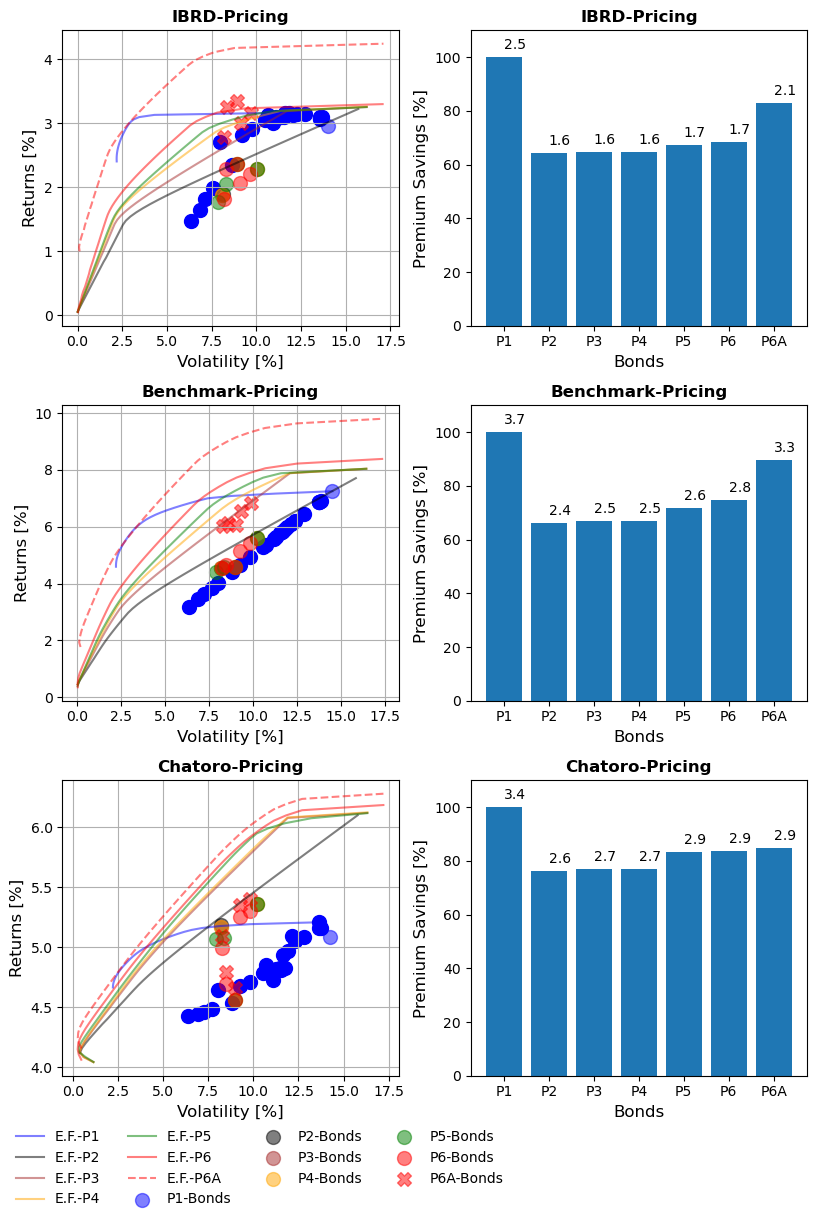

In [112]:
premiums_abs_keys = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P6A', 'P6AB']
premiums_abs = {key: {} for key in premiums_abs_keys}
premium_methods = ['ibrd','required', 'regression'] #'artemis'
premium_methods_title = ['IBRD-Pricing', 'Benchmark-Pricing', 'Chatoro-Pricing'] #'Artemis-Pricing'
num_plots = len(premium_methods)
fig, axes = plt.subplots(num_plots, 2, figsize=(8.27, 4 * num_plots))  # 2.99

for j, prem_mode in enumerate(premium_methods): 
    premiums_pool_s1 = {}
    premiums_pool_s2 = {}
    premiums_pool_s3 = {}
    premiums_pool_s4 = {}
    premiums_pool_s5 = {}
    premiums_pool_s5_a = {}
    premiums_pool_s5_a_b = {}
    premiums_pool_s5_a_r = {}
    for pool, prem_modes in premiums_s1.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s1:  # If the key already exists, sum the values
                    premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
    for pool, prem_modes in premiums_s2.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s2:  # If the key already exists, sum the values
                    premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
    for pool, prem_modes in premiums_s3.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s3:  # If the key already exists, sum the values
                    premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
    for pool, prem_modes in premiums_s4.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s4:  # If the key already exists, sum the values
                    premiums_pool_s4[key] += np.sum(values * nominal_s4[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s4[key] = np.sum(values * nominal_s4[pool])
    for pool, prem_modes in premiums_s5.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5:  # If the key already exists, sum the values
                    premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
    for pool, prem_modes in premiums_s5_a.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a:  # If the key already exists, sum the values
                    premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])
    for pool, prem_modes in premiums_s5_a_b.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_b:  # If the key already exists, sum the values
                    premiums_pool_s5_a_b[key] += np.sum(values * nominal_s5_a_b[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_b[key] = np.sum(values * nominal_s5_a_b[pool])
    for pool, prem_modes in premiums_s5_a_r.items():
        if prem_mode in prem_modes:
            for key, values in prem_modes[prem_mode].items():
                values = np.array(values)
                if key in premiums_pool_s5_a_r:  # If the key already exists, sum the values
                    premiums_pool_s5_a_r[key] += np.sum(values * nominal_s5_a_r[pool])
                else:  # Otherwise, initialize it with the current value
                    premiums_pool_s5_a_r[key] = np.sum(values * nominal_s5_a_r[pool])
            
    if prem_mode == 'ibrd':
        sng_ann_ret = sng_ann_ret_ibrd
        sng_ann_ret_df = sng_ann_ret_df_ibrd
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_ibrd
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_ibrd
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_ibrd
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_ibrd
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_ibrd
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_ibrd
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_ibrd
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_ibrd
        s1_ann_ret = s1_ann_ret_ibrd
        s2_ann_ret = s2_ann_ret_ibrd
        s3_ann_ret = s3_ann_ret_ibrd
        s4_ann_ret = s4_ann_ret_ibrd
        s5_ann_ret = s5_ann_ret_ibrd
        s5_a_ann_ret = s5_a_ann_ret_ibrd
        s5_a_b_ann_ret = s5_a_b_ann_ret_ibrd
        s5_a_r_ann_ret = s5_a_r_ann_ret_ibrd
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])
        threshold_ef = 0.024

    elif prem_mode == 'regression':
        sng_ann_ret = sng_ann_ret_regression
        sng_ann_ret_df = sng_ann_ret_df_regression
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_regr
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_regr
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_regr
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_regr
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_regr
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_regr
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_regr
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_regr
        s1_ann_ret = s1_ann_ret_regr
        s2_ann_ret = s2_ann_ret_regr
        s3_ann_ret = s3_ann_ret_regr
        s4_ann_ret = s4_ann_ret_regr
        s5_ann_ret = s5_ann_ret_regr
        s5_a_ann_ret = s5_a_ann_ret_regr
        s5_a_b_ann_ret = s5_a_b_ann_ret_regr
        s5_a_r_ann_ret = s5_a_r_ann_ret_regr
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][1])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][1])
        threshold_ef = 0.0465

    elif prem_mode == 'required':
        sng_ann_ret = sng_ann_ret_required
        sng_ann_ret_df = sng_ann_ret_df_required
        s1_tranches_ann_ret_df = s1_tranches_ann_ret_requ
        s2_tranches_ann_ret_df = s2_tranches_ann_ret_requ
        s3_tranches_ann_ret_df = s3_tranches_ann_ret_requ
        s4_tranches_ann_ret_df = s4_tranches_ann_ret_requ
        s5_tranches_ann_ret_df = s5_tranches_ann_ret_requ
        s5_a_tranches_ann_ret_df = s5_a_tranches_ann_ret_requ
        s5_a_b_tranches_ann_ret_df = s5_a_b_tranches_ann_ret_requ
        s5_a_r_tranches_ann_ret_df = s5_a_r_tranches_ann_ret_requ
        s1_ann_ret = s1_ann_ret_requ
        s2_ann_ret = s2_ann_ret_requ
        s3_ann_ret = s3_ann_ret_requ
        s4_ann_ret = s4_ann_ret_requ
        s5_ann_ret = s5_ann_ret_requ
        s5_a_ann_ret = s5_a_ann_ret_requ
        s5_a_b_ann_ret = s5_a_b_ann_ret_requ
        s5_a_r_ann_ret = s5_a_r_ann_ret_requ
        sng_cty_premium = []
        sng_cty_pay = []
        for cty in bond_metrics_sng_dic:
            sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][2])
            sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][2])
        threshold_ef = 0.0455
    else:
        print('Wrong input premium mode')
        continue

    df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
    df_returns_s1 = pd.DataFrame({f"{country} Returns": returns for country, returns in s1_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s2 = pd.DataFrame({f"{country} Returns": returns for country, returns in s2_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s3 = pd.DataFrame({f"{country} Returns": returns for country, returns in s3_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s4 = pd.DataFrame({f"{country} Returns": returns for country, returns in s4_tranches_ann_ret_df.items()}).dropna(axis=1)
    df_returns_s5 = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_tranches_ann_ret_df.items()}).dropna(axis=1)
    if prem_mode == 'ibrd':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_tranches_ann_ret_df.items()}).dropna(axis=1)
    elif prem_mode == 'required':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_b_tranches_ann_ret_df.items()}).dropna(axis=1)
    elif prem_mode == 'regression':
        df_returns_s5_a = pd.DataFrame({f"{country} Returns": returns for country, returns in s5_a_r_tranches_ann_ret_df.items()}).dropna(axis=1)
    
    

    r = np.mean(df_returns,axis=0)
    r_s1= np.mean(df_returns_s1,axis=0)
    r_s2= np.mean(df_returns_s2,axis=0)
    r_s3= np.mean(df_returns_s3,axis=0)
    r_s4= np.mean(df_returns_s4,axis=0)
    r_s5= np.mean(df_returns_s5,axis=0)
    r_s5_a= np.mean(df_returns_s5_a,axis=0)

    # Create a covariance matrix
    covar = df_returns.cov()
    covar_s1 = df_returns_s1.cov()
    covar_s2 = df_returns_s2.cov()
    covar_s3 = df_returns_s3.cov()
    covar_s4 = df_returns_s4.cov()
    covar_s5 = df_returns_s5.cov()
    covar_s5_a = df_returns_s5_a.cov()

    # Generate a series of target returns and corresponding risks
    target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
    risks = []
    for target_return in target_returns:
        weights, risk = minimize_risk(target_return, r, covar)
        risks.append(risk)

    ## Repeat for the second data set (df_returns_pool)
    risks_s1 = []
    target_returns_s1 = np.linspace(np.min(r_s1), np.max(r_s1), 50)
    for target_return in target_returns_s1:
        weights, risk = minimize_risk(target_return, r_s1, covar_s1)
        risks_s1.append(risk)

    risks_s2 = []
    target_returns_s2 = np.linspace(np.min(r_s2), np.max(r_s2), 50)
    for target_return in target_returns_s2:
        weights, risk = minimize_risk(target_return, r_s2, covar_s2)
        risks_s2.append(risk)

    risks_s3 = []
    target_returns_s3 = np.linspace(np.min(r_s3), np.max(r_s3), 50)
    for target_return in target_returns_s3:
        weights, risk = minimize_risk(target_return, r_s3, covar_s3)
        risks_s3.append(risk)

    risks_s4 = []
    target_returns_s4 = np.linspace(np.min(r_s4), np.max(r_s4), 50)
    for target_return in target_returns_s4:
        weights, risk = minimize_risk(target_return, r_s4, covar_s4)
        risks_s4.append(risk)

    risks_s5 = []
    target_returns_s5 = np.linspace(np.min(r_s5), np.max(r_s5), 50)
    for target_return in target_returns_s5:
        weights, risk = minimize_risk(target_return, r_s5, covar_s5)
        risks_s5.append(risk)

    risks_s5_a = []
    target_returns_s5_a = np.linspace(np.min(r_s5_a), np.max(r_s5_a), 50)
    for target_return in target_returns_s5_a:
        weights, risk = minimize_risk(target_return, r_s5_a, covar_s5_a)
        risks_s5_a.append(risk)

    filtered_target_returns = [value for value in target_returns if value > threshold_ef]
    filtered_risks = [risks[i] for i in range(len(target_returns)) if target_returns[i] > threshold_ef]
    axes[j, 0].plot(np.array(filtered_risks)*100, np.array(filtered_target_returns)*100, label="E.F.-P1", color='blue', alpha=0.5)
    axes[j, 0].plot(np.array(risks_s1)*100, np.array(target_returns_s1)*100, label="E.F.-P2", color='black', alpha=0.5)
    axes[j, 0].plot(np.array(risks_s2)*100, np.array(target_returns_s2)*100, label="E.F.-P3", color='brown', alpha=0.5)
    axes[j, 0].plot(np.array(risks_s3)*100, np.array(target_returns_s3)*100, label="E.F.-P4", color='orange', alpha=0.5)
    axes[j, 0].plot(np.array(risks_s4)*100, np.array(target_returns_s4)*100, label="E.F.-P5", color='green', alpha=0.5)
    axes[j, 0].plot(np.array(risks_s5)*100, np.array(target_returns_s5)*100, label="E.F.-P6", color='red', alpha=0.5)
    axes[j, 0].plot(np.array(risks_s5_a)*100, np.array(target_returns_s5_a)*100, label="E.F.-P6A", color='red', linestyle='--', alpha=0.5)

    for i, cty in enumerate(countries):
        if i == 0:
            axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', label='P1-Bonds', s=100, alpha=0.5)
        else: 
            axes[j, 0].scatter(np.std(sng_ann_ret[str(cty)])*100, np.mean(sng_ann_ret[str(cty)])*100, color='blue', s=100)
    for pool in s1_ann_ret:
        if pool == '1':
            axes[j, 0].scatter(np.std(s1_ann_ret[pool])*100, np.mean(s1_ann_ret[pool])*100, color='black', label=f'P2-Bonds', s=100, alpha=0.5)
        else:
            axes[j, 0].scatter(np.std(s1_ann_ret[pool])*100, np.mean(s1_ann_ret[pool])*100, color='black', s=100, alpha=0.5)
    for pool in s2_ann_ret:
        if pool == '1':
            axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='brown', label=f'P3-Bonds', s=100, alpha=0.5)
        else:
            axes[j, 0].scatter(np.std(s2_ann_ret[pool])*100, np.mean(s2_ann_ret[pool])*100, color='brown', s=100, alpha=0.5)
    for pool in s3_ann_ret:
        if pool == '1':
            axes[j, 0].scatter(np.std(s3_ann_ret[pool])*100, np.mean(s3_ann_ret[pool])*100, color='orange', label=f'P4-Bonds', s=100, alpha=0.5)
        else:
            axes[j, 0].scatter(np.std(s3_ann_ret[pool])*100, np.mean(s3_ann_ret[pool])*100, color='orange', s=100, alpha=0.5)
    for pool in s4_ann_ret:
        if pool == '1':
            axes[j, 0].scatter(np.std(s4_ann_ret[pool])*100, np.mean(s4_ann_ret[pool])*100, color='green', label=f'P5-Bonds', s=100, alpha=0.5)
        else:
            axes[j, 0].scatter(np.std(s4_ann_ret[pool])*100, np.mean(s4_ann_ret[pool])*100, color='green', s=100, alpha=0.5)
    for pool in s5_ann_ret:
        if pool == '1':
            axes[j, 0].scatter(np.std(s5_ann_ret[pool])*100, np.mean(s5_ann_ret[pool])*100, color='red', label=f'P6-Bonds', s=100, alpha=0.5)
        else:
            axes[j, 0].scatter(np.std(s5_ann_ret[pool])*100, np.mean(s5_ann_ret[pool])*100, color='red', s=100, alpha=0.5)
    for pool in s5_a_ann_ret:
        if pool == '1':
            if prem_mode == 'ibrd':
                axes[j, 0].scatter(np.std(s5_a_ann_ret[pool])*100, np.mean(s5_a_ann_ret[pool])*100, color='red', label=f'P6A-Bonds', marker='X', s=100, alpha=0.5)
            elif prem_mode == 'required':
                axes[j, 0].scatter(np.std(s5_a_b_ann_ret[pool])*100, np.mean(s5_a_b_ann_ret[pool])*100, color='red', label=f'P6A-Bonds', marker='X', s=100, alpha=0.5)
            else:
                axes[j, 0].scatter(np.std(s5_a_r_ann_ret[pool])*100, np.mean(s5_a_r_ann_ret[pool])*100, color='red', label=f'P6A-Bonds', marker='X', s=100, alpha=0.5)
        else:
            if prem_mode == 'ibrd': 
                axes[j, 0].scatter(np.std(s5_a_ann_ret[pool])*100, np.mean(s5_a_ann_ret[pool])*100, color='red', marker='X', s=100, alpha=0.5)
            elif prem_mode == 'required':
                axes[j, 0].scatter(np.std(s5_a_b_ann_ret[pool])*100, np.mean(s5_a_b_ann_ret[pool])*100, color='red', marker='X', s=100, alpha=0.5)
            else:
                axes[j, 0].scatter(np.std(s5_a_r_ann_ret[pool])*100, np.mean(s5_a_r_ann_ret[pool])*100, color='red', marker='X', s=100, alpha=0.5)

    axes[j, 0].set_xlabel("Volatility [%]", fontsize=12)
    axes[j, 0].set_ylabel("Returns [%]", fontsize=12)
    axes[j, 0].grid(True)
    axes[j, 0].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')

    x_labels = ["P1", "P2", "P3", "P4", "P5", "P6", "P6A"]

    s = sng_cty_premium
    if prem_mode == 'ibrd':
        prem_diff = [np.sum(s)/np.sum(s), 
                     np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     np.sum(premiums_pool_s2['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s4['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5_a['Total_alt'])/np.sum(s)]
    elif prem_mode == 'required':
        prem_diff = [np.sum(s)/np.sum(s), 
                     np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     np.sum(premiums_pool_s2['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s4['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5_a_b['Total_alt'])/np.sum(s)]
    else:
        prem_diff = [np.sum(s)/np.sum(s), 
                     np.sum(premiums_pool_s1['Total_alt'])/np.sum(s), 
                     np.sum(premiums_pool_s2['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s3['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s4['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5['Total_alt'])/np.sum(s),
                     np.sum(premiums_pool_s5_a_r['Total_alt'])/np.sum(s)]

    tot_pay_s1 = 0

    for pool in es_metrics_s1:
        tot_pay_s1 += es_metrics_s1[pool]['Payout']


    if prem_mode == 'ibrd':
        im = [np.sum(s)/np.sum(sng_cty_pay), 
              np.sum(premiums_pool_s1['Total_alt'])/tot_pay_s1, 
              np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s3['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s4['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5_a['Total_alt'])/tot_pay_s1]
    elif prem_mode == 'required':
        im = [np.sum(s)/np.sum(sng_cty_pay), 
              np.sum(premiums_pool_s1['Total_alt'])/tot_pay_s1, 
              np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s3['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s4['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5_a_b['Total_alt'])/tot_pay_s1]
    else:
        im = [np.sum(s)/np.sum(sng_cty_pay), 
              np.sum(premiums_pool_s1['Total_alt'])/tot_pay_s1, 
              np.sum(premiums_pool_s2['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s3['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s4['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5['Total_alt'])/tot_pay_s1,
              np.sum(premiums_pool_s5_a_r['Total_alt'])/tot_pay_s1]

    for q in range(len(im)):
        axes[j, 1].text(x_labels[q], prem_diff[q]*100+3, round(im[q],1))
    axes[j, 1].bar(x_labels, np.array(prem_diff)*100, label='Premium Savings')
    axes[j, 1].set_xlabel("Bonds", fontsize=12)
    axes[j, 1].set_ylabel("Premium Savings [%]", fontsize=12)
    axes[j, 1].set_ylim(0, 110)
    axes[j, 1].tick_params(axis='y')
    axes[j, 1].set_title(f"{premium_methods_title[j]}", fontsize=12, fontweight='bold')
    
    premiums_abs['P1'][prem_mode] = np.sum(sng_cty_premium)/len(sng_ann_ret['212'])
    premiums_abs['P2'][prem_mode] = premiums_pool_s1['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P3'][prem_mode] = premiums_pool_s2['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P4'][prem_mode] = premiums_pool_s3['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P5'][prem_mode] = premiums_pool_s4['Total_alt']/len(sng_ann_ret['212'])
    premiums_abs['P6'][prem_mode] = premiums_pool_s5['Total_alt']/len(sng_ann_ret['212'])
    if prem_mode == 'ibrd':
        premiums_abs['P6A'][prem_mode] = premiums_pool_s5_a['Total_alt']/len(sng_ann_ret['212'])
    elif prem_mode == 'required':
        premiums_abs['P6A'][prem_mode] = premiums_pool_s5_a_b['Total_alt']/len(sng_ann_ret['212'])
    elif prem_mode == 'regression':
        premiums_abs['P6A'][prem_mode] = premiums_pool_s5_a_r['Total_alt']/len(sng_ann_ret['212'])

    print(f"Sng Premiums {prem_mode}: {premiums_abs['P1'][prem_mode]}; {prem_diff[0]}")
    print(f"P2 Premiums {prem_mode}: {premiums_abs['P2'][prem_mode]}; {prem_diff[1]}")
    print(f"P3 Premiums {prem_mode}: {premiums_abs['P3'][prem_mode]}; {prem_diff[2]}")
    print(f"P4 Premiums {prem_mode}: {premiums_abs['P4'][prem_mode]}; {prem_diff[3]}")
    print(f"P5 Premiums {prem_mode}: {premiums_abs['P5'][prem_mode]}; {prem_diff[4]}")
    print(f"P6 Premiums {prem_mode}: {premiums_abs['P6'][prem_mode]}; {prem_diff[5]}")
    print(f"P6A Premiums {prem_mode}: {premiums_abs['P6A'][prem_mode]}; {prem_diff[6]}")

nominal_sng = 0
for key in nominal_sng_dic:
    nominal_sng += nominal_sng_dic[key]
print(f"Sng Nominal: {nominal_sng}")
print(f"P2 Nominal: {nominal_s1['1']}; {nominal_s1['1']/nominal_sng}")
nominal_pool_s2 = 0
for key in nominal_s2:
    nominal_pool_s2 += nominal_s2[key]
print(f"P3 Nominal: {nominal_pool_s2}; {nominal_pool_s2/nominal_sng}")
nominal_pool_s3 = 0
for key in nominal_s3:
    nominal_pool_s3 += nominal_s3[key]
print(f"P4 Nominal: {nominal_pool_s3}; {nominal_pool_s3/nominal_sng}")
nominal_pool_s4 = 0
for key in nominal_s4:
    nominal_pool_s4 += nominal_s4[key]
print(f"P5 Nominal: {nominal_pool_s4}; {nominal_pool_s4/nominal_sng}")
nominal_pool_s5 = 0
for key in nominal_s5:
    nominal_pool_s5 += nominal_s5[key]
print(f"P6 Nominal: {nominal_pool_s5}; {nominal_pool_s5/nominal_sng}")



handles0, labels0 = axes[j, 0].get_legend_handles_labels()
fig.legend(
    handles0,
    labels0,
    loc='lower left',
    bbox_to_anchor=(0.01, -0.02),
    ncol=4,
    frameon=False,
)

#handles1, labels1 = axes[j, 1].get_legend_handles_labels()  
#fig.legend(
#    handles1,
#    labels1,
#    loc='lower right',
#    bbox_to_anchor=(0.90, 0.01),
#    ncol=1,
#    frameon=False
#)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


In [113]:
coverages = []
for key in bond_metrics_sng_dic:
    coverages.append(bond_metrics_sng_dic[key]['Coverage'][0])

exp_lsss = []
att_probs = []
var_95 = []
var_99 = []
es_95 = []
es_99 = []
for key in premium_dic_sng_dic:
    exp_lsss.append(premium_dic_sng_dic[key]['exp_loss'])
    att_probs.append(premium_dic_sng_dic[key]['att_prob'])
    var_99.append(sng_es_metrics[str(key)][0])
    var_95.append(sng_es_metrics[str(key)][2])
    es_99.append(sng_es_metrics[str(key)][4])
    es_95.append(sng_es_metrics[str(key)][6])

exp_lsss = np.array(exp_lsss) * 100
att_probs = np.array(att_probs) * 100
coverages = np.array(coverages) * 100
var_95 = np.array(var_95) * 100
var_99 = np.array(var_99) * 100
es_95 = np.array(es_95) * 100
es_99 = np.array(es_99) * 100

data = {
    'Country': countries_str,
    'Coverage': np.round(coverages,1),
    'Expected Loss': np.round(exp_lsss, 1),
    'Attachment Probability': np.round(att_probs,1),
    'VaR 95': np.round(var_95,1),
    'VaR 99': np.round(var_99,1),
    'ES 95': np.round(es_95,1),
    'ES 99': np.round(es_99,1)
}
df = pd.DataFrame(data)

# Calculate the mean, min, and specified percentiles for each column
statistics = df.describe(percentiles=[.25, .5, .75, 1.0])

# Display the statistics
print(statistics)

latex_table = df.to_latex(index=False, float_format="%.1f", caption="Example Table", label="tab:example_table")
print(latex_table)

        Coverage  Expected Loss  Attachment Probability     VaR 95     VaR 99  \
count  25.000000       25.00000               25.000000  25.000000  25.000000   
mean   80.096000        1.87200                3.748000   7.608000  54.456000   
std    13.901093        0.91766                2.229185  11.481105  28.731459   
min    45.600000        0.40000                0.400000   0.000000   0.000000   
25%    78.600000        1.20000                2.200000   0.000000  52.200000   
50%    86.900000        1.90000                3.900000   0.000000  68.000000   
75%    90.000000        2.70000                5.600000  19.200000  70.700000   
100%   92.000000        3.30000                7.700000  28.100000  78.300000   
max    92.000000        3.30000                7.700000  28.100000  78.300000   

           ES 95      ES 99  
count  25.000000  25.000000  
mean   60.868000  87.732000  
std    15.835212   5.710788  
min    47.400000  69.300000  
25%    49.700000  84.800000  
50%    55

In [114]:
prem_mode = 'ibrd'
premiums_pool_s1 = {}
premiums_pool_s2 = {}
premiums_pool_s3 = {}
premiums_pool_s4 = {}
premiums_pool_s5 = {}
premiums_pool_s5_a = {}
for pool, prem_modes in premiums_s1.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s1:  # If the key already exists, sum the values
                premiums_pool_s1[key] += np.sum(values * nominal_s1[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s1[key] = np.sum(values * nominal_s1[pool])
for pool, prem_modes in premiums_s2.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s2:  # If the key already exists, sum the values
                premiums_pool_s2[key] += np.sum(values * nominal_s2[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s2[key] = np.sum(values * nominal_s2[pool])
for pool, prem_modes in premiums_s3.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s3:  # If the key already exists, sum the values
                premiums_pool_s3[key] += np.sum(values * nominal_s3[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s3[key] = np.sum(values * nominal_s3[pool])
for pool, prem_modes in premiums_s4.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s4:  # If the key already exists, sum the values
                premiums_pool_s4[key] += np.sum(values * nominal_s4[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s4[key] = np.sum(values * nominal_s4[pool])
for pool, prem_modes in premiums_s5.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s5:  # If the key already exists, sum the values
                premiums_pool_s5[key] += np.sum(values * nominal_s5[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s5[key] = np.sum(values * nominal_s5[pool])
for pool, prem_modes in premiums_s5_a.items():
    if prem_mode in prem_modes:
        for key, values in prem_modes[prem_mode].items():
            values = np.array(values)
            if key in premiums_pool_s5_a:  # If the key already exists, sum the values
                premiums_pool_s5_a[key] += np.sum(values * nominal_s5_a[pool])
            else:  # Otherwise, initialize it with the current value
                premiums_pool_s5_a[key] = np.sum(values * nominal_s5_a[pool])

sng_cty_premium = []
sng_cty_pay = []
for cty in bond_metrics_sng_dic:
    sng_cty_premium.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
    sng_cty_pay.append(bond_metrics_sng_dic[cty]['Summed Payments'][0])

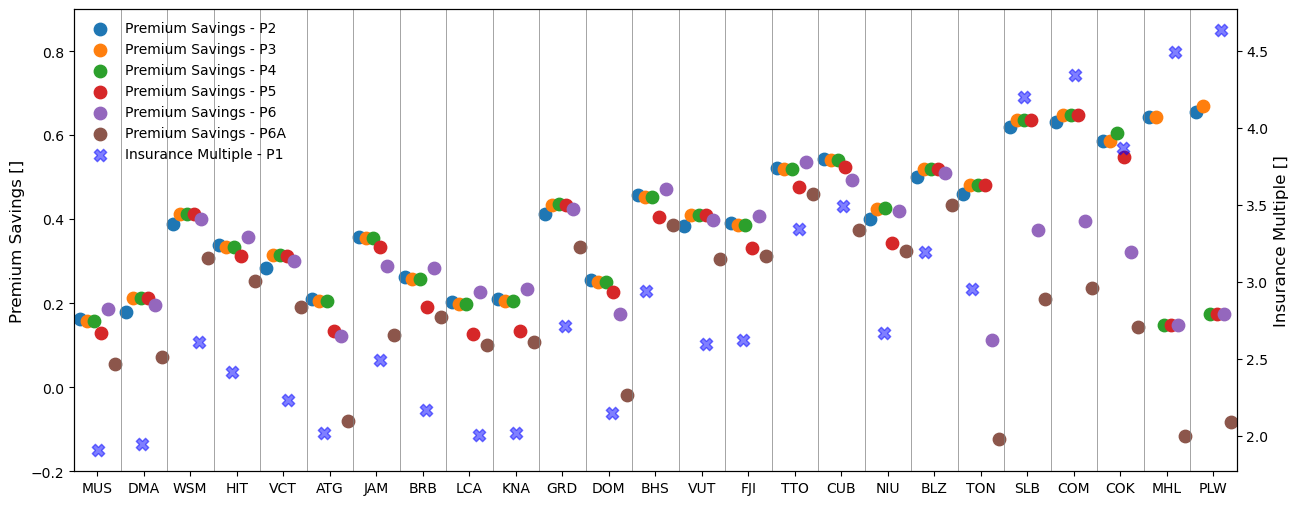

In [115]:
s = {'P1': None, 'P2': [], 'P3': [], 'P4': [], 'P5': [], 'P6': [], 'P6A': []}
n = []
s['P1'] = sng_cty_premium

for cty in countries:
    s['P2'].append(np.sum(premiums_pool_s1[cty]))
    s['P3'].append(np.sum(premiums_pool_s2[cty]))
    s['P4'].append(np.sum(premiums_pool_s3[cty]))
    s['P5'].append(np.sum(premiums_pool_s4[cty]))
    s['P6'].append(np.sum(premiums_pool_s5[cty]))
    s['P6A'].append(np.sum(premiums_pool_s5_a[cty]))

prem_diff = {}
for key in s:
    prem_diff[key] = (1-(np.array(s[key])/np.array(s['P1']))).tolist()

im = (np.array(sng_cty_premium)/np.array(sng_cty_pay)).tolist()

def jitter(x):
    return x + random.uniform(-0.2, .2)

type_ids = {}
type_ids_ls = []
for i, cty in enumerate(countries_str):
    type_ids[cty] = i
    type_ids_ls.append(i)

jitter_type_im = [jitter(type_ids[cty]) for cty in countries_str]
jitter_type_ps = [jitter(type_ids[cty]) for cty in countries_str]

fig, ax = plt.subplots(figsize=(15,6))  # Correct the typo

iterator = -0.375
for key in prem_diff:
    if key != 'P1':
        ax.scatter(np.array(type_ids_ls)+iterator, prem_diff[key], label=f'Premium Savings - {key}', s=80)
        iterator += 0.1525
ax.set_ylabel("Premium Savings []", fontsize=12)
ax.tick_params(axis='y')
ax.set_ylim(-0.2,0.8)


# Vertical lines at specified positions
x_positions = np.arange(0.5, len(countries_str) - 1 + 0.6).tolist()
for x in x_positions:
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=0.5)

# Secondary y-axis for Premium Savings
ax2 = ax.twinx()
# Scatter plot for Insurance Multiple
ax2.scatter(jitter_type_im, im, color='blue', label='Insurance Multiple - P1', marker='X', s=80, alpha=0.5)
ax2.set_xlabel("Bonds", fontsize=12)
ax2.set_ylabel("Insurance Multiple []", fontsize=12)
ax2.tick_params(axis='y')

# X-axis limits and labels
ax.set_xlim(-0.5, len(countries_str) - 0.5)
ax.set_ylim(-0.2,0.9)
ax.set_xticks(np.arange(0, len(countries_str)).tolist())
ax.set_xticklabels(list(type_ids.keys()))

handles1, labels1 = ax.get_legend_handles_labels()  
handles2, labels2 = ax2.get_legend_handles_labels() 
plt.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper left',
    #bbox_to_anchor=(0.85, 0.03),
    ncol=1,
    frameon=False
)
plt.show()


In [ ]:
import dill 
output_path = "C:/Users/Kai/OneDrive - UT Cloud/Documents/Studium_ETH/Thesis/sessions/all_pools_c_tot.pkl"
with open(output_path, 'wb') as file:
    dill.dump_session(file)

c:\Users\Kai\miniforge3\envs\climada_env\Lib\site-packages\dill\_dill.py:452: UserWarning: This figure was saved with matplotlib version 3.9.2 and loaded with 3.10.0 so may not function correctly.
  obj = StockUnpickler.load(self)
c:\Users\Kai\miniforge3\envs\climada_env\Lib\site-packages\dill\_dill.py:452: UserWarning: This figure was saved with matplotlib version 3.9.2 and loaded with 3.10.0 so may not function correctly.
  obj = StockUnpickler.load(self)
